# Предсказание снижения покупательской активности клиентов интернет магазина "В один клик". 

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

1. Нужно построить модель, которая **предскажет вероятность снижения покупательской активности клиента в следующие три месяца**.
2. В исследование нужно включить дополнительные данные финансового департамента о **прибыльности клиента**: какой доход каждый покупатель приносил компании за последние три месяца.
3. Используя данные модели и данные о прибыльности клиентов, нужно **выделить сегменты покупателей и разработать для них персонализированные предложения**.

Решать задачу необходимо в **два этапа**:
1. **Разработать модель**, которая предскажет вероятность снижения покупательской активности.
2. **Выделите сегмент покупателей**, проанализируйте его и предложите, как увеличить его покупательскую активность. Используйте данные моделирования, данные о прибыли покупателей и исходные данные (если понадобятся). По желанию вы можете проанализировать больше одного сегмента.


## Описание данных

`market_file.csv` - Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении:
- `id` — номер покупателя в корпоративной базе данных.
- `Покупательская активность` — рассчитанный класс покупательской активности **(целевой признак): «снизилась» или «прежний уровень».**
- `Тип сервиса` — уровень сервиса, например **«премиум»** и **«стандарт».**
- `Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- `Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- `Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце.
- `Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- `Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.
- `Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- `Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.
- `Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта.
- `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.



`market_money.csv` - Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом:

- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксирована выручка. Например, **'текущий_месяц'** или **'предыдущий_месяц'**.
- `Выручка` — сумма выручки за период.

`market_time.csv` - Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода:
- `id`— номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксировано общее время.
- `минут` — значение времени, проведённого на сайте, в минутах.

`money.csv` - Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю:
- `id` — номер покупателя в корпоративной базе данных.
- `Прибыль` — значение прибыли.

## Импорт необходимых библиотек

In [1]:
!pip install shap
!pip install scikit-learn==1.1.3 -q # -q убирает необязательные выводы в командах Linux

In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import shap

from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV,
    RandomizedSearchCV
)

from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler
)

from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (
    roc_auc_score, 
    f1_score, 
    recall_score, 
    precision_score, 
    accuracy_score
)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


## Загрузка данных

In [3]:
market_file = pd.read_csv('/datasets/market_file.csv', sep=',', decimal='.')
print(market_file.info())
market_file.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


Опишим тезисно данные и наметим шаги предобработки.
- В датасете отсутствуют пропуски. 
- В названиях некоторых столбцов присутствуют пробелы. 
- Столбец `Маркет_актив_6_мес` имеет строковый тип данных при числовом содержании. 
- Столбец `Акционные_покупки` имеет строковый тип данных при числовом содержании.

In [4]:
market_money = pd.read_csv('/datasets/market_money.csv', sep=',', decimal='.')
print(market_money.info())
market_money.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB
None


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


- В данных отсутствуют пропуски.
- Столбец `Выручка` имеет строковый тип данных при числовом содержании.

In [5]:
market_time = pd.read_csv('/datasets/market_time.csv', sep=',', decimal=',')
print(market_time.info())
market_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB
None


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


- В данных отсутствуют пропуски.
- Содержание столбцов соответствует типу данных в них.

In [6]:
money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')
print(money.info())
money.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB
None


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


- В данных отсутствуют пропуски.
- Типы данных соответствуют содержанию столбцов.

#### Вывод
 В ходе загрузки данных и знакомства с ними были выявлены следующие моменты, на которые следует обрать внимание на этапе предобработки:
- В датасете `market_file` следует заменить пробелы в названия стобцов на нижнее подчеркивание;
- В датасете `market_file` следует изменить типы данных в столбцах `Маркет_актив_6_мес` и `Акционные_покупки` со строковых на численные;
- В датасете `market_money` следует изменить тип данных в столбце `Выручка` на численный;
- Во всех датасетах для удобства следует привести все символы к нижнему регистру.

## Предобработка данных

Для начала напишем функцию, которая преобразует наши столбцы в нужный вид.

In [7]:
def preprocessing(data):
    columns = ['Маркет_актив_6_мес', 'Акционные_покупки', 'Выручка']
    for column in columns:
        if column in data.columns:
            data[column] = pd.to_numeric(data[column], errors='coerce')
    data.columns = data.columns.str.lower().str.replace(' ', '_')
    return data

In [8]:
market_file = preprocessing(market_file)
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

In [9]:
market_money = preprocessing(market_money)
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [10]:
market_time = preprocessing(market_time)
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [11]:
money = preprocessing(money)
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Готово! Теперь проверим содержимое числовых и строковых столбцов на предмет выбросов и дубликатов. Тут нам в помощь функция.

In [12]:
def check_data(data):
    
    #Количество дубликатов
    print('Количество дубликатов:', data.duplicated().sum())
    print()
    #Неявные дубликаты в строковых столбцах
    object_columns = data.select_dtypes(include='object').columns
    for column in object_columns:
        print(f'Cписок уникальных значений для столбца {column}')
        if column in data.columns:
            print(data[column].unique())
            print()
            
    #Числовой тип данных
    numeric_columns = data.select_dtypes(include='number').columns
    
    # Уникальные значения в числовых столбцах
    for column in numeric_columns:
        print(f'Cписок уникальных значений для столбца {column}')
        if column in data.columns:
            print(data[column].sort_values().unique())
            print()
            
    #Гистограммы для числового типа данных
    for column in numeric_columns:
        plt.figure(figsize=(6, 3))
        sns.histplot(data[column], bins=10, kde=True)
        plt.title(f'Гистограмма для {column}')
        plt.xlabel(column)
        plt.ylabel('Частота')
        plt.show() 
        

Количество дубликатов: 11

Cписок уникальных значений для столбца покупательская_активность
['Снизилась' 'Прежний уровень']

Cписок уникальных значений для столбца тип_сервиса
['премиум' 'стандартт' 'стандарт']

Cписок уникальных значений для столбца разрешить_сообщать
['да' 'нет']

Cписок уникальных значений для столбца популярная_категория
['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']

Cписок уникальных значений для столбца маркет_актив_6_мес
[0.9 1.4 1.5 1.7 2.4 2.6 2.7 2.9 3.  3.1 3.2 3.3 3.4 3.5 3.6 3.7 3.8 3.9
 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.  5.1 5.2 5.3 5.4 5.5 5.6 5.7
 5.8 5.9 6.1 6.3 6.6]

Cписок уникальных значений для столбца маркет_актив_тек_мес
[3 4 5]

Cписок уникальных значений для столбца длительность
[ 110  121  125  129  131  132  133  134  135  136  140  142  145  147
  148  149  150  151  152  153  154  157  159  160  161  162  163  165
  166  1

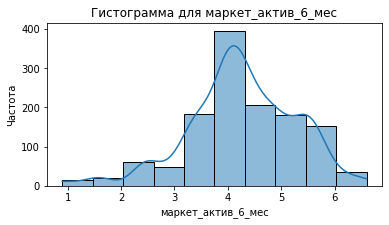

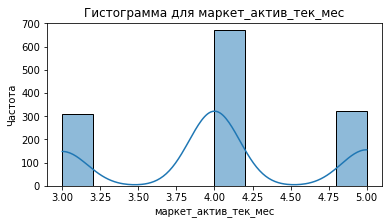

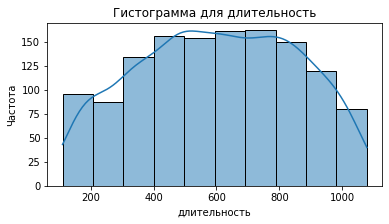

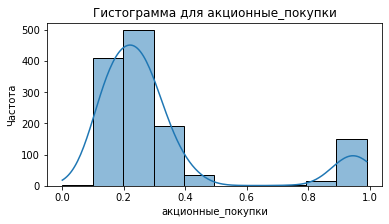

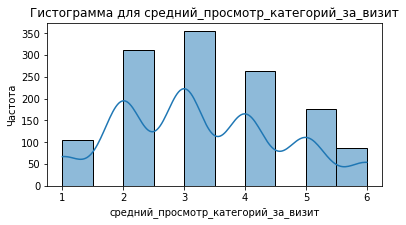

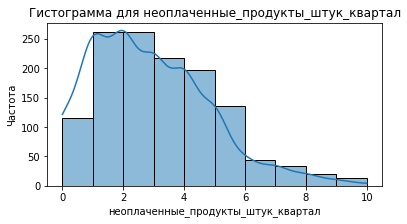

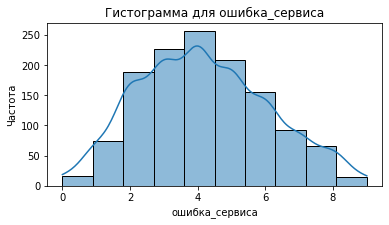

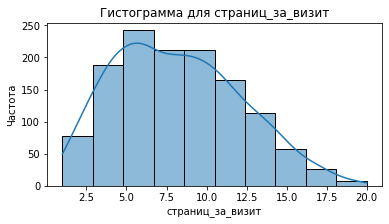

In [13]:
check_data(market_file.drop('id', 1))

- В датасете найдено 11 строк-дубликатов;
- В столбце `тип_сервиса` найден неявный дубликат `стандартт`;
- На первый взгляд в количественных стобцах отсутствуют выбросы и аномальные значения; Типы распределений данных в столбцах рассмотрим на этапе исследовательнского анализа данных;
- В датасете присутствуют значения как с мелким, так и с крупным регистром, приведем все значения к нижнему регистру.

In [14]:
market_file['покупательская_активность'] = market_file['покупательская_активность'].str.lower()
market_file['покупательская_активность'].unique()

array(['снизилась', 'прежний уровень'], dtype=object)

In [15]:
market_file.duplicated().sum()

0

Явные дубликаты не обнаружены.

In [16]:
market_file['тип_сервиса'] = market_file['тип_сервиса'].replace('стандартт', 'стандарт')
market_file['тип_сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

Приступим к следующему датасету

Количество дубликатов: 746

Cписок уникальных значений для столбца период
['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']

Cписок уникальных значений для столбца выручка
[     0.    2758.7   2890.  ...   7605.3   7799.4 106862.2]



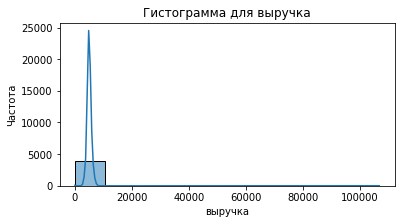

In [17]:
check_data(market_money.drop('id', 1))

Дубликаты можно объяснить тем, что разные пользователи могут приносить компании одинаковую прибыль. Столбец выручка содержит выброс. Выведем строку с аномально высоким значением.

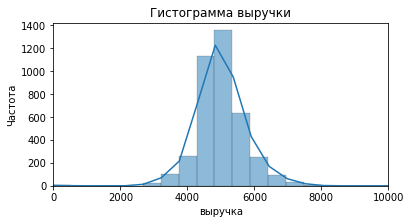

In [18]:
plt.figure(figsize=(6, 3))
sns.histplot(market_money['выручка'], bins=200, kde=True)
plt.title(f'Гистограмма выручки')
plt.xlim(0, 10000)
plt.xlabel('выручка')
plt.ylabel('Частота')
plt.show()

Посмотрим количество строк, значение которых превышает 10000

In [19]:
market_money[market_money['выручка'] > 10000]

,id,период,выручка
98,215380,текущий_месяц,106862.2


Всего одна строка. Это меньше 1% данных, можно ее удалить.

In [20]:
market_money = market_money[market_money['выручка'] < 10000].reset_index(drop=True)

Количество дубликатов: 2561

Cписок уникальных значений для столбца период
['текущий_месяц' 'предыдцщий_месяц']

Cписок уникальных значений для столбца минут
[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]



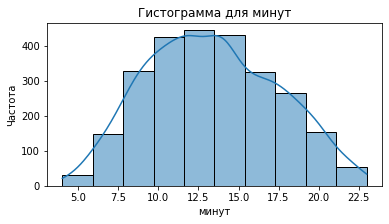

In [21]:
check_data(market_time.drop('id', 1))

- В столбце `минут` отсутствуют выбросы;
- В столбце `период` имеется опечатка в наименовании периода;

In [22]:
market_time.duplicated().sum()

0

In [23]:
market_time['период'] = market_time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')
market_time['период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

Количество дубликатов: 900

Cписок уникальных значений для столбца прибыль
[0.86 0.98 1.06 1.08 1.33 1.37 1.38 1.39 1.4  1.48 1.54 1.55 1.57 1.63
 1.64 1.68 1.81 1.82 1.83 1.84 1.87 1.92 1.95 1.97 2.   2.02 2.03 2.07
 2.08 2.09 2.1  2.11 2.13 2.15 2.16 2.18 2.19 2.21 2.23 2.24 2.26 2.27
 2.29 2.32 2.33 2.34 2.35 2.36 2.37 2.38 2.39 2.41 2.42 2.43 2.44 2.45
 2.46 2.47 2.48 2.49 2.5  2.51 2.53 2.54 2.55 2.57 2.59 2.6  2.61 2.63
 2.64 2.66 2.67 2.68 2.69 2.7  2.71 2.72 2.73 2.74 2.75 2.76 2.77 2.78
 2.79 2.8  2.81 2.82 2.83 2.84 2.85 2.86 2.87 2.88 2.9  2.91 2.92 2.93
 2.94 2.95 2.96 2.97 2.98 2.99 3.   3.01 3.03 3.04 3.05 3.06 3.07 3.08
 3.09 3.1  3.11 3.12 3.13 3.14 3.15 3.16 3.17 3.18 3.19 3.2  3.21 3.22
 3.23 3.24 3.25 3.26 3.27 3.28 3.29 3.3  3.31 3.32 3.33 3.34 3.35 3.36
 3.37 3.38 3.39 3.4  3.42 3.43 3.44 3.45 3.46 3.47 3.48 3.49 3.5  3.51
 3.52 3.53 3.54 3.55 3.56 3.57 3.58 3.59 3.6  3.61 3.62 3.63 3.64 3.65
 3.66 3.67 3.68 3.69 3.7  3.71 3.72 3.73 3.74 3.75 3.76 3.77 3.78 3.79
 3

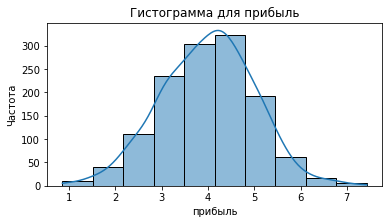

In [24]:
check_data(money.drop('id', 1))

In [25]:
money.duplicated().sum()

0

Данные в датасете распределены нормально, выбросов не обнаружено, как и дубликатов.

#### Вывод
В ходе предобработки данных были предприняты следующие шаги по устранению недочетов в данных:
- Мы **написали функцию `preprocessing`**, которая исправляет недочеты в названиях столбцов наших датафреймов:

    1) Все символы в названиях столбцов были приведены к нижнему регистру;
    
    2) Пробелы в названиях столбцов были заменены на нижнее подчеркивание.
___    
- Мы **написали функцию `check_data`**, которая перебирает каждый столбец и выводит список уникальных значений, считает дубликаты, а также выводит на экран гистограммы столбцов с количественным типом данных: 

    1) С помощью функции был обнаружен неявный дубликат в столбце `тип_сервиса` датафрейма `market_file`;
    
    2) Также мы обнаружили один выброс в датасете `market_money` в столбце с выручками. Выброс всего один и принадлежит пользователю с `id` **215380**. Мы его удалили, это менее 1% данных
    
    3) Обнаружена орфографическая ошибка в столбце `тип_сервиса`
___    
В основном все недочеты, как мне кажется, являются следствием человеческого фактора.

## Исследовательский анализ данных

Начнем исследовательский анализ данных с написания функциии, ведь так удобнее)

In [26]:
def eda(data):
    #строковые столбцы
    object_columns = data.select_dtypes(include='object').columns
    
    #числовые столбцы
    numeric_columns = data.select_dtypes(include='number').columns
    
    #гистограммы и ящики с усами для числовых столбцов
    for column in numeric_columns:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
        
        sns.histplot(data[column], kde=False, bins=20, color='blue', alpha=0.5, ax=axes[0])
        axes[0].set_title(f'Гистограмма столбца\n{column}')
        axes[0].set_ylabel('Частота')
        axes[0].set_xlabel(f'{column}')
        axes[0].axvline(data[column].mean(), color='red', linestyle='dashed', linewidth=2, label='Среднее')
        axes[0].axvline(data[column].median(), color='blue', linestyle='dashed', linewidth=2, label='Медиана')
        axes[0].legend()

        sns.boxplot(x=data[column], ax=axes[1], color='skyblue')
        axes[1].set_title(f'Ящик с усами для\n{column}')
        axes[1].set_xlabel(f'{column}')

        plt.tight_layout()
        plt.show()

        print(data[column].describe())
    
    #Диаграммы для категориальных столбцов
    for column in object_columns:
        labels = data[column].value_counts().index
        sizes = data[column].value_counts().values

        plt.figure(figsize=(5, 5))
        plt.pie(
            sizes, 
            labels=labels, 
            autopct='%1.1f%%', 
            startangle=90, 
            colors=['lightblue', 'lightgreen', 'lightyellow', 'lightcoral', 'lightgrey', 'lightsalmon'])
        plt.title(f'Соотношение значений столбца\n{column} в датасете')
        plt.show()
        print(data[column].value_counts())


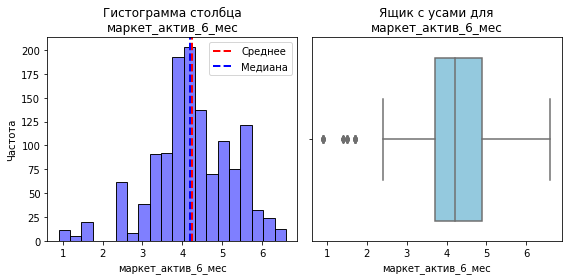

count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: маркет_актив_6_мес, dtype: float64


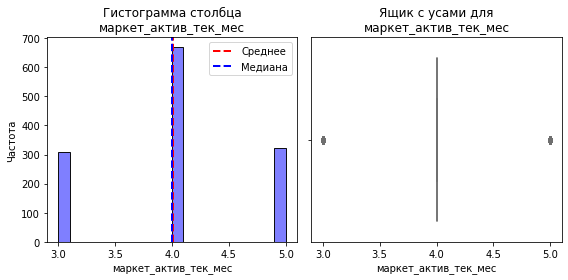

count    1300.000000
mean        4.011538
std         0.696868
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: маркет_актив_тек_мес, dtype: float64


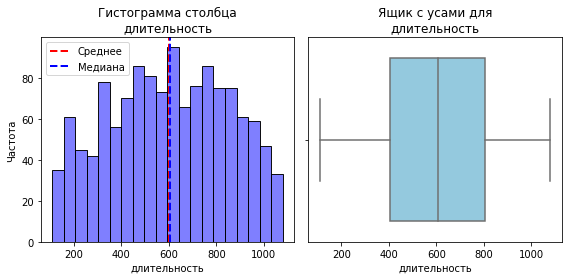

count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: длительность, dtype: float64


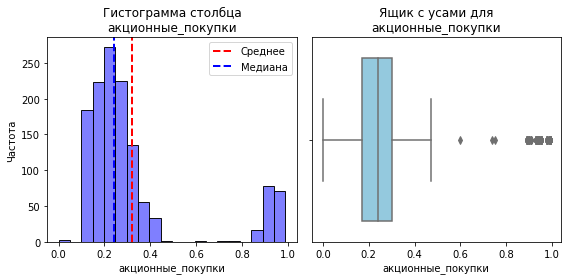

count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: акционные_покупки, dtype: float64


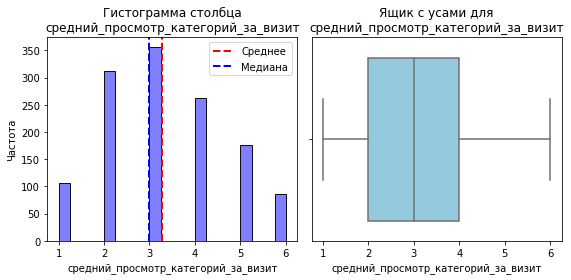

count    1300.00000
mean        3.27000
std         1.35535
min         1.00000
25%         2.00000
50%         3.00000
75%         4.00000
max         6.00000
Name: средний_просмотр_категорий_за_визит, dtype: float64


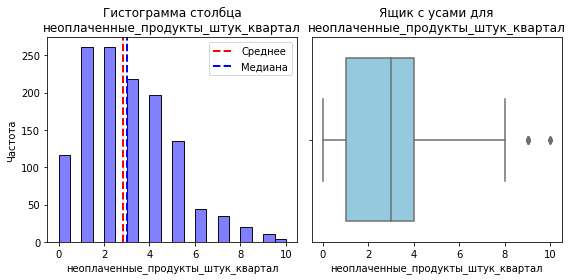

count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: неоплаченные_продукты_штук_квартал, dtype: float64


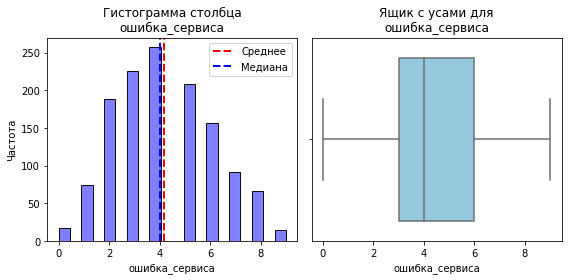

count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: ошибка_сервиса, dtype: float64


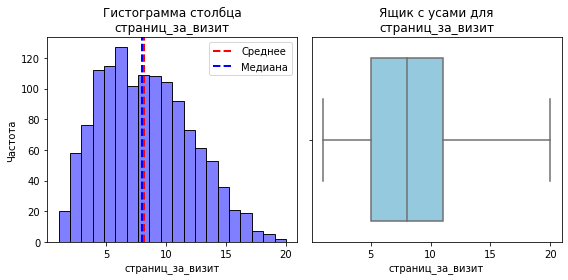

count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: страниц_за_визит, dtype: float64


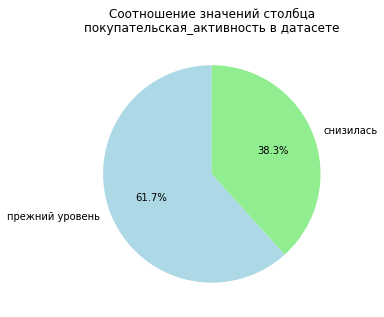

прежний уровень    802
снизилась          498
Name: покупательская_активность, dtype: int64


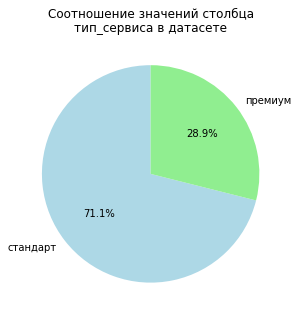

стандарт    924
премиум     376
Name: тип_сервиса, dtype: int64


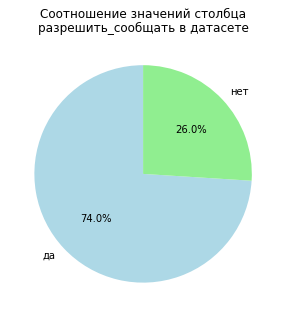

да     962
нет    338
Name: разрешить_сообщать, dtype: int64


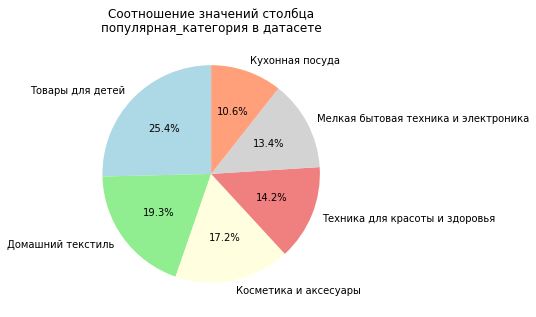

Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: популярная_категория, dtype: int64


In [27]:
eda(market_file.drop('id', 1))

Приступим к изучению наших графиков. Начнем со столбца, содержащего значения маркетинговых взаимодействий с покупателем за последние 6 месяцев `маркет_актив_6_мес`:
 - Распределение данных стремится к **нормальному**, среднее и медиана равны 4.25 и 4.20 соответственно. 
 - Заметны незначительные **выбросы**. Они приходятся на количество маркетинговых коммуникаций с покупателями, число которых **меньше двух**. Видимо в данных присутствует некоторое количество клиентов, маркетинговые коммуникации с которыми были сведены к минимуму. Чуть позже **посмотрим на этих пользователей и попытаемся предположить с чем это может быть связано.** Возможно нам придется посмотреть на то, какое взаимодействие ведется с этими пользователями в текущем месяце.
___ 
На очереди столбец `маркет_актив_тек_мес`:
 - На этапе предобработки мы выяснили, что столбец с маркетинговыми взаимодействиями в текущем месяце содержит три класса: 3, 4, 5. Разумнее будет **построить столбчатую диаграмму**, нежели гистограмму, поэтому сейчас рассмотрим основные статистики этого столбца.
 - Среднее и медиана ровны 4.01 и 4. соответсвенно. 
___ 
Следующий столбец `длительность` показывает нам продолжительность пребывания пользователя на сайте с момента регистрации:
 - Распределение нормальное, со средним и медианой 601.9 и 606 соответственно. В основном в датасете присутствуют пользователи, которые прошли регистрацию около 600 с лишнем дней назад. Это чуть больше полутора лет назад.
 - Самый старый пользователь прошел регистрацию 1079 дней назад. Самый последний пользователь, который присоединился к сообществу сайта прошел регистрацию 110 дней назад.
___ 
Столбец `акционные_покупки` содержит информацию о среднемесячной доле покупок по акции от общего числа покупок за 6 мес.:
 - Распределение на гистограмме бимодальное, пользователи разделились на два кластера:
      1. Пользователи, доля акционных покупок которых в среднем составляет от 10% - 40%;
      2. Пользователи, доля акционных покупок которых составила от 90% - 100%.
   
   Это можно объяснить тем, что есть пользователи, которые совершают покупки только, когда появляются акционные позиции на сайте. В то время как первая категория пользователей регулярно совершают покупки вне зависимости от того действует ли на товар скидка или акция. 
 - Ящик с усами показывает нам, что в столбце присутствуют выбросы. Как раз таки они и являются теми самыми пользователями, которые в большинстве своем проявляют свою покупательскую активность только когда появляется акционный товар. Далее мы **подробно рассмотрим строки, где доля акционных покупок превышает 0.6**
 - Среднее и медиана равны 0.32 и 0.24 соответственно. 
 - Обнаруженные выбросы мы оставим, т.к. наша модель должна также учитывать и поведение пользователей, доля акционных покупок которых приближена к 100%
___ 
Столбец `средний просмотр категорий за визит`:
 - В среднем покупатель просматривает около 3 категорий за визит. 
 - Распределение можно охарактеризовать, как нормальное, выбросы по гистограмме и ящику с усами отсутствуют. 
 - Максимально количество категорий, просмотренное за визит составило 6. 
___
Общее число неоплаченных продуктов в корзине `неоплаченные_продукты_штук_квартал`:
 - Судя по графикам в среднем у пользователей имеется 3 неоплаченнных товара в корзине.
 - При этом присутствуют пользователи, у которых может быть по 9-10 неоплаченных товаров. Такие пользователи представляют собой выбросы в нашей выборке. Их можно увидеть на ящике с усами. 
 - Среднее и медиана недалеко убежали друг от друга: 2.84 и 3 соответственно. 
 - В дальнейшем **исследуем пользователей, у которых в корзине имеется 9 и более неоплаченных товаров.**
___ 
Число сбоев, которое коснулось пользователей за время посещения сайта `ошибка_сервиса`:
 - Распределение у данных нормальное. В среднем пользователи сталкивались с ошибками сайта 4 раза.
 - При этом есть пользователи, которые ни разу так и не столкнулись с ошибкой сайта. А есть и те, кто пережил неполадки на сайте аж 9 раз! **Дальше посмотрим как ошибки на сайте повлияли на покупательскую способность пользователей**
 - Судя по гистограмме и ящику с усами выбросы в данных отсутствуют.
___
Среднее количество страниц, которое просмотрели пользователи за визит на сайт за последние 3 мес `страниц_за_визит`:
 - Распределение похоже на нормальное. Среднее и медиана равны 8.17 и 8 соответственно. Заметно небольшое удлинение хвоста гистограммы справа. Это связано с тем, что в среднем пользователи посещают от 4 до 11 страниц за визит, но также есть пользователи, которые просматривают большее количество страниц за визит.
 - Максимально количество страниц, которое посетил пользователь составило 20. Такие высокие значения могут быть связаны с тем, что пользователи иногда любят просматривать товары, рекомендованные сайтом. Или же пользователи пытались найти конкретный товар, но в этой категории очень много похожих и приходится заходить на страницу и читать его характеристики. 
___
На очереди целевой признак `покупательская_активность`:
 - Наблюдается дисбаланс классов. В данном случае он обусловлен спецификой задачи: Пользователей, чья покупательская активность снизилась, будет меньше, нежели пользователей, чья покупательская активность осталась на том же уровне.
 - Несмотря на наличие дисбаланса, примеров минорного класса, как мне кажется, достаточно для того, чтобы модель обучилась, так что мы не будем применять техники сэмплирования при подготовке данных к обучению модели. Достаточно будет стратифицировать наши выборки и передать логрегу и SVС параметр `class_weight = 'balanced'`
 - У 38% пользователей покупательская активность снизилась.
___ 
`тип_сервиса`:
 - Конечно, основное количество пользователей пользуются стандартной подпиской.
 - Лишь 29% пользователей оформили себе премиум.
 - Далее проведем исследование касательно того, **как подписка влияет на покупательскую активность.**
___ 
`разрешить_сообщать` - согласие пользователя на доп. предложения о товаре:
 - Большинство пользователей (74%) дали свое согласие на доп. предложения о товаре.
 - 26% пользователей решили отказаться от доп. предложения. Позже мы посмотрим, **как это влияет на их покупательскую активность, а также будет неплохо посмотреть какое количество страниц посетили эти пользователи.** Есть предположение, что такие пользователи совершают очень мало покупок, если не одну вовсе. 
___ 
`популярная_категория` - самая популярная категория за последние 6 мес.:
 - Самая популярная категория у пользователей `Товары для детей`. Видимо, одна из основных целевых аудиторий сайта - это родители. Доля пользователей, покупающих товары из этой категории составила 25%
 - Вторая по популярности категория товаров на сайте - это `Домашний текстиль`. На эту категорию приходится 19% пользователей.
 - Третья по величине категория `Косметика и аксесуары` составила 17%
 - Остальные категории в общей сложности составили 39% от всей выборки.

Теперь обратим внимание на пользователей, маркетинговые коммуникации с которыми меньше 2.

In [28]:
print('Число пользователей, маркетинговые коммуникации с которыми меньше двух в месяц:', market_file[market_file['маркет_актив_6_мес'] < 2].shape[0])
market_file[market_file['маркет_актив_6_мес'] < 2].head(10)


Число пользователей, маркетинговые коммуникации с которыми меньше двух в месяц: 36


,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
30,215378,снизилась,стандарт,да,1.7,3,488,0.39,Техника для красоты и здоровья,5,1,4,3
32,215380,снизилась,премиум,нет,1.7,4,637,0.94,Техника для красоты и здоровья,3,2,4,7
38,215386,снизилась,стандарт,да,1.5,3,495,0.98,Домашний текстиль,2,3,7,5
47,215395,снизилась,премиум,да,1.5,5,645,0.27,Товары для детей,3,3,6,5
55,215403,снизилась,премиум,да,1.7,5,771,0.39,Техника для красоты и здоровья,1,8,2,5
61,215409,снизилась,премиум,да,1.4,4,857,0.95,Кухонная посуда,3,4,5,5
63,215411,снизилась,стандарт,да,1.7,4,756,0.33,Товары для детей,2,3,7,4
70,215418,снизилась,стандарт,нет,1.7,4,472,0.94,Домашний текстиль,2,6,4,3
81,215429,снизилась,премиум,нет,0.9,4,690,0.24,Домашний текстиль,2,5,7,4
108,215456,снизилась,стандарт,да,1.7,4,449,0.23,Косметика и аксесуары,3,4,4,5


Как можно заметить, для пользователей, с которыми маркетинговые коммуникации снижены, характерно снижение покупательской активности. Посчитаем кол-во строк, где покупательская активность снизилась.

In [29]:
print('Кол-во пользователей, чья покупательская активность снижена а коммуникаций в течение 6 мес. было меньше двух', 
      market_file[(market_file['маркет_актив_6_мес'] < 2)&(market_file['покупательская_активность'] == 'снизилась')]
      ['id'].count())

market_file[market_file['маркет_актив_6_мес'] < 2][['маркет_актив_6_мес', 'маркет_актив_тек_мес']].mean()

Кол-во пользователей, чья покупательская активность снижена а коммуникаций в течение 6 мес. было меньше двух 34


маркет_актив_6_мес      1.369444
маркет_актив_тек_мес    3.972222
dtype: float64

Итак, почти все пользователи, маркетинговое взаимодействие с которыми в теч. 6 мес. было меньше двух снизили свою покупательскую активность. При этом можно заметить, что в текущем месяце маркетинговые взаимодействия стали уже выше. 

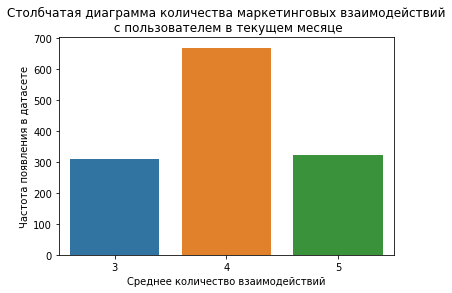

In [30]:
sns.barplot(x=market_file['маркет_актив_тек_мес'].value_counts().index, 
            y=market_file['маркет_актив_тек_мес'].value_counts().values)

plt.title('Столбчатая диаграмма количества маркетинговых взаимодействий\n с пользователем в текущем месяце')
plt.xlabel('Среднее количество взаимодействий')
plt.ylabel('Частота появления в датасете')
plt.show()

Видно, что чаще всего в текущем месяце с пользователями в среднем проводилось 4 маркетинговые коммуникации. Остальные значения имеют примерно одинаковую частоту появления в датасете. 

Теперь изучим пользователей, доля акционных покупок у которых выше 0.6

In [31]:
print('Число пользователей, доля акционных покупок у которых выше 0.6:', 
      market_file[market_file['акционные_покупки'] > 0.6].shape[0])
market_file[market_file['акционные_покупки'] > 0.6].head(10)

Число пользователей, доля акционных покупок у которых выше 0.6: 167


,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
1,215349,снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
3,215351,снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
14,215362,снизилась,премиум,да,4.2,4,438,0.74,Домашний текстиль,3,4,6,4
16,215364,снизилась,премиум,да,4.3,4,708,0.98,Домашний текстиль,3,3,3,3
17,215365,снизилась,стандарт,да,3.9,4,167,0.95,Техника для красоты и здоровья,6,4,2,5
25,215373,снизилась,премиум,нет,3.8,3,811,0.90,Товары для детей,2,5,5,3
26,215374,снизилась,стандарт,нет,2.9,5,268,0.98,Домашний текстиль,6,3,2,2
27,215375,снизилась,премиум,да,3.0,4,558,0.89,Товары для детей,3,3,7,4
28,215376,снизилась,стандарт,да,2.4,3,534,0.98,Домашний текстиль,4,1,5,4


Судя по всему для таких пользователей тоже характерно снижение покупательской активности. Посмотрим насколько это критичный показатель. 

In [32]:
print('Кол-во пользователей, чья покупательская активность снижена а доля акционных товаров выше 0.6:', 
      market_file[(market_file['акционные_покупки'] > 0.6)&(market_file['покупательская_активность'] == 'снизилась')]
      ['id'].count())

Кол-во пользователей, чья покупательская активность снижена а доля акционных товаров выше 0.6: 134


Видимо, таких пользователей действительно можно охарактеризовать как тех, кто пользуется сервисом, только когда видит какие-то акционные позиции. Посмотрим сколько таких пользователей согласились получать доп. предложения о товарах.

In [33]:
print('Кол-во пользователей, кто согласился получать доп. предложения:', 
     market_file[(market_file['акционные_покупки'] > 0.6)&(market_file['разрешить_сообщать'] == 'да')]
      ['id'].count())

Кол-во пользователей, кто согласился получать доп. предложения: 119


Такие пользователи также ожидают, что во время покупки акционных позиций сайт им будет также предлагать сопутствующие товары по выгодным ценам. Таких пользователей можно охарактеризовать, как низколояльных по отношению к маркетплейсу, т.к. они не совершают покупок в безакционный период.

Посмотрим на пользователей, у которых в корзине имееются неоплаченные товары в количестве более 8 штук.

In [34]:
print('Количество пользователей с общим числом неоплаченных товаров более 8:', 
      market_file[market_file['неоплаченные_продукты_штук_квартал'] > 8].shape[0])
market_file[market_file['неоплаченные_продукты_штук_квартал'] > 8]


Количество пользователей с общим числом неоплаченных товаров более 8: 14


,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
72,215420,снизилась,стандарт,да,3.5,5,449,0.35,Домашний текстиль,1,9,2,2
73,215421,снизилась,премиум,нет,4.0,5,523,0.94,Техника для красоты и здоровья,1,10,7,5
117,215465,снизилась,стандарт,да,3.5,5,449,0.28,Домашний текстиль,1,9,2,2
118,215466,снизилась,премиум,нет,2.4,5,523,0.30,Техника для красоты и здоровья,1,10,1,4
176,215524,снизилась,стандарт,да,3.0,3,474,0.23,Техника для красоты и здоровья,1,10,4,2
186,215534,снизилась,премиум,нет,4.0,4,419,0.93,Товары для детей,1,9,3,3
204,215552,снизилась,стандарт,да,0.9,4,624,0.89,Косметика и аксесуары,1,9,5,1
216,215564,снизилась,стандарт,нет,3.9,3,618,0.24,Техника для красоты и здоровья,2,10,3,5
246,215594,снизилась,стандарт,да,4.2,4,627,0.90,Товары для детей,6,9,5,8
251,215599,снизилась,стандарт,да,3.4,4,716,0.28,Домашний текстиль,2,9,4,6


У всех пользователей, в корзине которых имеется более 8 неоплаченных товаров покупательская активность снижена. Это может быть связано с тем, что такие пользователи, как правило просто откладывают большое количество товаров, не рассчитывая изначально их покупать. Возможно они просто не хотят терять их и планируют когда-то в будущем покупку. Также у пользователей могут быть какие-то финансовые трудности, которые могут охарактеризовать незавершенность покупательских действий. 

Теперь обратим внимание как ошибки на сайте повлияли на покупательскую активность. 

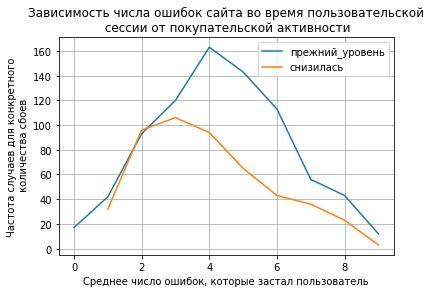

In [35]:
site_errors = market_file.pivot_table(index='ошибка_сервиса', 
                        columns='покупательская_активность', 
                        values='id', 
                        aggfunc='count')
site_errors.columns = ['прежний_уровень', 'снизилась']

plt.plot(site_errors)
plt.legend(site_errors)
plt.grid()

plt.title('Зависимость числа ошибок сайта во время пользовательской\n сессии от покупательской активности')
plt.xlabel('Среднее число ошибок, которые застал пользователь')
plt.ylabel('Частота случаев для конкретного\n количества сбоев')
plt.show()


На графике видно, что большинство пользователей все же не пугает наличие сбоев на сайте. Тем не менее есть группа пользователей, чья покупательская активность снижается. Как правило, таким пользователям достаточно двух ошибок, чтобы их желание покупать на сайте снизилось. Приятно знать, то таких пользователей все таки мало. 

Далее посмотрим зависимость покупательской активности от типа сервиса.

In [36]:
service_type = market_file.pivot_table(index='тип_сервиса', 
                        columns='покупательская_активность', 
                        values='id', 
                        aggfunc='count')

service_type.columns = ['прежний_уровень', 'снизилась']
service_type['доля_сниж'] = service_type['снизилась'] / (service_type['снизилась'] + service_type['прежний_уровень'])
service_type

,прежний_уровень,снизилась,доля_сниж
тип_сервиса,,,
премиум,206,170,0.452128
стандарт,596,328,0.354978


По таблице видно, что доля снижения покупательской активности у пользователей с премиум подпиской выше, нежели у пользователей со стандартным типом сервиса. При этом, почти половина премиум пользователей снизили свою покупательскую активность. Возможно это связано с тем, что пользователь ожидал в премиум подписке увидеться что-то большее, чем ему предоставил маркетплейс и его ожидания не оправдались. Отсюда и снижение покупательской активности.

Посмотрим теперь ситуацию с пользователями, которые дали запрет на доп. предложения о товаре

In [37]:
print('Число пользователей, которые не хотят получать доп предложения о подписке:', 
      market_file[market_file['разрешить_сообщать'] == 'нет'].shape[0])
market_file[market_file['разрешить_сообщать'] == 'нет'].head(10)

Число пользователей, которые не хотят получать доп предложения о подписке: 338


,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
2,215350,снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
4,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
7,215355,снизилась,стандарт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4
15,215363,снизилась,стандарт,нет,4.9,4,923,0.29,Товары для детей,6,0,3,1
18,215366,снизилась,стандарт,нет,3.8,3,209,0.22,Товары для детей,5,3,7,7
21,215369,снизилась,стандарт,нет,2.7,4,607,0.21,Товары для детей,2,2,3,4
24,215372,снизилась,стандарт,нет,4.8,4,566,0.39,Косметика и аксесуары,2,1,4,5
25,215373,снизилась,премиум,нет,3.8,3,811,0.90,Товары для детей,2,5,5,3
26,215374,снизилась,стандарт,нет,2.9,5,268,0.98,Домашний текстиль,6,3,2,2
31,215379,снизилась,стандарт,нет,3.4,4,436,0.98,Товары для детей,3,0,3,5


Посмотрим сколько из них имеют сниженную покупательскую активность

In [38]:
print('Кол-во пользователей со сниженной покупательской активностью при отсутствии доп. предложений о товаре:', 
      market_file[(market_file['разрешить_сообщать'] == 'нет')&(market_file['покупательская_активность'] == 'снизилась')]
      ['id'].count())

Кол-во пользователей со сниженной покупательской активностью при отсутствии доп. предложений о товаре: 127


Посмотрим товары какой категории чаще всего покупают такие пользователи.

In [39]:
market_file[(market_file['разрешить_сообщать'] == 'нет')]['популярная_категория'].value_counts()

Товары для детей                        98
Домашний текстиль                       64
Косметика и аксесуары                   61
Мелкая бытовая техника и электроника    47
Техника для красоты и здоровья          44
Кухонная посуда                         24
Name: популярная_категория, dtype: int64

Чаще всего такие пользователи берут товары для детей. 

In [40]:
print('Среднее число страниц за визит', market_file[(market_file['разрешить_сообщать'] == 'нет')]['страниц_за_визит'].mean())

Среднее число страниц за визит 8.159763313609467


У таких пользователей количество посещенных страниц никак не отличается от среднего по всей выборке

Можно сделать вывод, что пользователи, отказавшиеся от доп. предложений о товаре изначально проходили регистрацию на маркетплейсе из-за конкретных товаров и купив их больше не совершали никаких действий. 

**Вывод по датафрейму**

В ходе исследовательского анализа данных были обнаружены следующие закономерности в данных:
- У пользователей, среднее количество маркетинговых взаимодействий с которыми за последние 6 месяцев меньше двух, наблюдается тенденция в снижении покупательской активности. 
___
- Судя по столбцу с информацией о доле акционных покупок, пользователи делятся на две группы:
   
   1) регулярные пользователи;
   
   2) пользователи, совершающие покупки только в период акций.
    
  При этом покупательская активность пользователей, доля акционных покупок которых составила более 0.6, имеет тенденцию снижаться. Такие пользователи также хотят получать дополнительные предложения об акционном товаре. Можно предположить, что такие пользователи охарактеризованы низкой лояльностью к маркетплейсу.
___
- Исследуя количество неоплаченных товаров в корзине у пользователей была выявлена следующая закономерность: уровень покупательской активности снижен у пользователей, которые хранят в корзине 9 и более неоплаченных товаров. Такие пользователи, как правило, либо не определились с покупкой, либо имеют финансовые трудности, либо же просто любят откладывать товары в корзину, чтобы вернуться к их покупке позже.
___
- Исследуя то, как ошибки на сайте влияют на покупательскую активность, было обнаружено, что у пользователей, чья покупательская активность снижена было достаточно от двух сбоев, чтобы желание совершать целевое действие на сайте снизилось. При этом таких пользователей мало.
___
- Было обнаружено, что пользователи с премиум подпиской чаще снижают покупательскую активность, нежели пользователи со стандартной подпиской. Скорее всего это связано с тем, что они имеют завышенные ожидания к сервису, и по итогу эти ожидания просто не оправдываются, что и влечет за собой снижение покупательской активности. 
___ 
- Пользователи, отказавшиеся от доп. предложений о товаре также имею тенденцию сниженной покупательской активности. Это может быть связано с тем, что зайдя на маркетплейс они преследуют цель приобрести конкретный товар, который есть только на этом маркетплейсе и больше на нем не появляться. 

Далее мы проведем исследование с таблицей, содержащей информацию о выручке, которую покупатели приносят маркетплейсу `market_money`

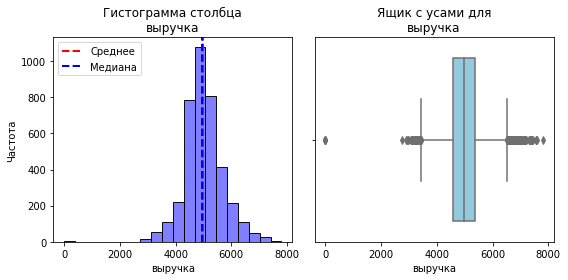

count    3899.00000
mean     4999.57743
std       706.99988
min         0.00000
25%      4590.10000
50%      4957.00000
75%      5363.00000
max      7799.40000
Name: выручка, dtype: float64


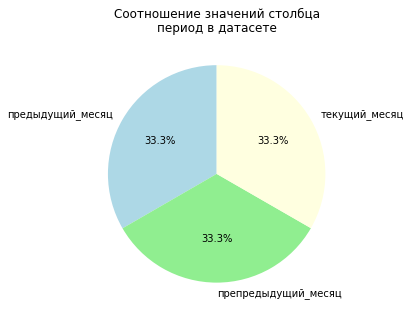

предыдущий_месяц       1300
препредыдущий_месяц    1300
текущий_месяц          1299
Name: период, dtype: int64


In [41]:
eda(market_money.drop('id', 1))

Итак, изучим столбец `выручка`:
- Распределение нормальное со средним и медианой 4999.6 и 4957 соответственно. Видимые смещения и удлиненные хвосты отсутствуют. Об этом можно судить и по примерно одинаковым значениям мер центральной тенденции.
- Минимальная выручка, которую принес пользователь составила 0 р., этот пользователь и представился выбросом, судя по ящику с усами.
- Также на ящике с усами видно, что выбросы присутствуют слева от левого уса межквартильного размаха.
- Справа от межквартильного размаха тоже присутствуют выбросы, **посмотрим сколько % они составляют от всего датафрейма**
- Кластеризации пользователей не обнаружено. 
___
На очереди категориальный столбец `период`:
- Изучим цифры, **посчитав какую выручку имел магазин с пользователей в каждом месяце по отдельности**
- Данные по трем месяцам распределены равномерно

Для того, чтобы посмотреть на значения датафрейма, которые являются выбросами рассчитаем межквартильный размах и получимим минимум и максимум, которые не считаются выбросами

In [42]:
iqr = np.percentile(market_money['выручка'], 75) - np.percentile(market_money['выручка'], 25)
min_dot = np.percentile(market_money['выручка'], 25) - 1.5 * iqr
max_dot = np.percentile(market_money['выручка'], 75) + 1.5 * iqr
print('Точка минимум, не являющаяся выбросом:', min_dot)
print('Точка максимум, не являющаяся выбросом:', max_dot)

Точка минимум, не являющаяся выбросом: 3430.750000000001
Точка максимум, не являющаяся выбросом: 6522.349999999999


Теперь посчитаем процент выбросов, который присутствует в данных 

In [43]:
market_money[(market_money['выручка'] < min_dot)|(market_money['выручка'] > max_dot)].shape[0] / market_money.shape[0] * 100

4.462682739163888

почти 5% данных составляют выбросы. Не будем их выбрасывать, т.к. в дальнейшем планируется объединить датафреймы и эти значения могут оказаться важными для предсказания минорного класса целевой переменной. 

Теперь посчитаем количество выручки, которую получил магазин с пользователей в прошлом и текущем месяце.

In [44]:
print('Выручка за предыдущий месяц составила', market_money[market_money['период'] == 'препредыдущий_месяц']['выручка'].sum())
print('Выручка за предыдущий месяц составила', market_money[market_money['период'] == 'предыдущий_месяц']['выручка'].sum())
print('Выручка за текущий месяц составила', market_money[market_money['период'] == 'текущий_месяц']['выручка'].sum())

Выручка за предыдущий месяц составила 6272769.0
Выручка за предыдущий месяц составила 6417996.5
Выручка за текущий месяц составила 6802586.899999999


Теперь перед нами стоит задача вычеслить пользователей, у которых отсутствуют покупки хотя бы в одном из 3 месяцев, т.к. у них активность менее 3 месяцев. Для этого вычеслим `id` пользователей в таблице с выручкой, где выручка составила 0 руб.

In [45]:
market_money[market_money['выручка'] == 0]

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


Всего 6 строк. Убираем их из таблицы.

In [46]:
market_money = market_money.drop(market_money[market_money['выручка'] == 0].index).reset_index(drop=True)
market_money.shape

(3893, 3)

**Вывод по датафрейму**

В ходе исследовательского анализа данных датафрейма `market_money` были найдены следующие особенности:
- В столбце с информацие о выручке, которую принесли пользователи маркетплейсу были обнаружены выбросы. Они составили почти 5% данных. С этими выбросами мы ничего не делали, т.к. `id` пользователей с этими строками могут принадлежать пользователям с минорным классом нашей целевой переменной и модель из-за этого может хуже обучиться
___
- За препредыдущий месяц пользователи принесли компании 6,3 млн рублей.
- За предыдущий месяц пользователи принесли компании почти 6,4 млн рублей.
- За текущий месяц пользователи принесли компании около 6,8 млн. рублей.
___
- Мы удалили пользователей, чья активность была менее 3 мес. Их было 3

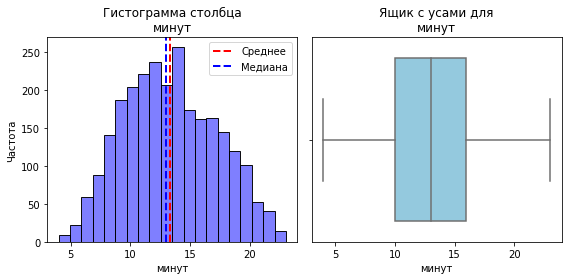

count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64


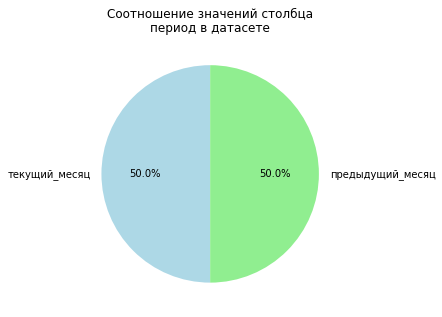

текущий_месяц       1300
предыдущий_месяц    1300
Name: период, dtype: int64


In [47]:
eda(market_time.drop('id', 1))

Столбец с временем `минут` содержит информацию о том, сколько времени пользователь проводит на сайте в минутах:
- Распределение данных в столбце нормальное со средним и медианой 13.3 и 13 соответственно. Скосов, удлиненных хвостов в ходе анализа не обнаружено.
- Минимальное количество времени, которое пользователь проводит на маркетплейсе составило 4 минуты. Максимальное кол-во времени -  23 минуты. 
- В среднем пользователь тратит 13 минут на маркетплейсе.
___
Столбец `период`:
- В датасете одинаковое кол-во наблюдений за предыдущий и текущий месяц

Посмотрим теперь сколько времени в среднем проводят пользователи на маркетплейсе в текущем месяце и сравним этот показатель с предыдущим месяцем.

In [48]:
print('Среднее время пребывания на сайте в пред. месяце', market_time[market_time['период'] == 'предыдущий_месяц']
      ['минут'].mean().round(2))
print('Среднее время пребывания на сайте в тек. месяце', market_time[market_time['период'] == 'текущий_месяц']
      ['минут'].mean().round(2))

Среднее время пребывания на сайте в пред. месяце 13.47
Среднее время пребывания на сайте в тек. месяце 13.2


Среднее время, проведенное на сайте за предыдущий и текущий месяц на сайте никак не поменялось

**Вывод по датафрейму**

В ходе исследовательского анализа датафрейма с информацией о времени пребывания на сайте были выявлены следующие закономерности:
- Среднее время, которое проводит пользователь на сайте составило 13 минут. Причем независимо от исследуемого периода. 
- Минимальное время, которое пользователи проводили на сайте составило 4 минуты, а максимальное 23 минуты.

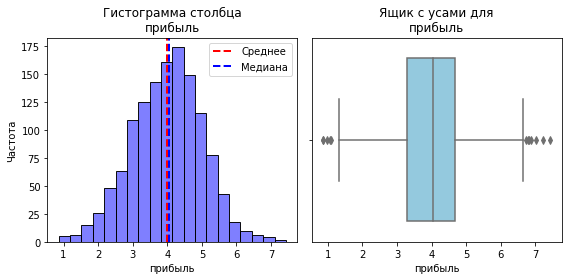

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64


In [49]:
eda(money.drop('id', 1))

Данный столбец содержит информацию о средней прибыли, которую магазин получает от пользователя за последние 3 месяца. Судя по всему значения в столбце соответствуют определенной сумме средств, которую магазин получает с пользователя. Предположу, что это 10000 рублей, но настаивать не стану, т.к. лучше уточнить этот момент у тех, кто выгружал данные:
 - Распределение нормальное со средним и медианой 3.997 и 4.045 соответственно. Сильных отклонений не наблюдается
 - На ящике с усами заметны выбросы по обе стороны от усов. 
 - Средняя среднемесячная прибыль за 3 месяца с одного пользователя составила около 4 ед. 

#### Вывод 
В ходе исследовательского анализа данных были выявлены следующие особенности и закономерности в данных:
- В датасете присутствовали клиенты, среднее число маркетинговых коммуникаций с которыми на 6 мес. было меньше двух. Изучив поведение таких клиентов мы пришли к выводу, что такое число взаимодействий неизбежно привело к снижению покупательской активности.
___
- Средняя продолжительность пребывания пользователей на сайте составила чуть больше 600 дней.
___
- В ходе исследования покупательской активности пользователей и доли акционных покупок на сайте было обнаружено, что пользователи сегментировались на две группы: первая совершает покупки на сайте вне зависимости от того  есть там акции или нет; вторая группа пользуется маркетплейсом исклбчительно при наличии акций. При этом покупательская способность пользователей второй группы снижена, т.к. из-за преобладания акционных покупок (более 60% покупок). Скорее всего это связано с тем, что такие пользователи, как правило, низколояльны к самому сервису, т.к. не совершают покупки в безакционный период. Но тем не менее, такие пользователи соглашаются на доп. предложения о товаре в надежде, что смогут урвать еще какой-то товар по выгодному предложению.
___
- В среднем покупатели просматривают около 3 категорий на маркетплейсе за визит.
___
- Исследуя количество неоплаченных товаров в корзине мы обнаружили интересную закономерность: пользователи, которые держат в корзине 9 и более неоплаченных товаров имеют сниженную покупательскую активность. Скорее всего это может быть связанно с финансовым состоянием этих пользователей или же с тем, что они изначально не планируют ничего покупать, а просто решают сохранить товар в корзине, чтобы не потерять. Важно отметить, что при нормальных диапазонах пользователи в среднем имеют около 3 неоплаченных товаров в корзине за квартал
___ 
- Количество ошибок с которым когда-либо сталкивались пользователи, пребывая на сайте, показало нам, что в большинстве своем пользователей не пугает наличие каких-то сбоев на площадке. При этом, если изучать пользователей, чья покупательская активность снизилась, то стоит отметить, что им достаточно 2 сбоев на своем веку, чтобы желание заходить на сайт снизилось, а значит и покупательская активность. 
___
- Когда мы исследовали покупательскую активность среди пользователей с разными типами сервиса, то пришли к выводу о том, что пользователи с премиум подпиской имеют тенденцию чаще разочаровываться в сервисе и снижать свою покупательскую активность, нежели пользователи со стандартным сервисом. Скорее всего это связано с тем, что оплачивая премиум пользователи ожидают чего-то большего от обслуживания, но их ожидания не оправдываются. 
___ 
- В среднем пользователи просматривают около 8 страниц за визит.
___
- В ходе исследования целевого признака был обнаружен дисбаланс классов. В рамках нашей ситуации он вызван спецификой исследуемой среды. К тому же данных для обучения модели все же достаточно, поэтому на этапе подготовки данных к обучению модели мы не будем использовать сэмплирование, а просто стратифицируем выборки и передадим некоторым моделям информацию о дисбалансе.
___
- Пользователи, отказавшиеся от доп. предложений о товаре также имею тенденцию сниженной покупательской активности. Это может быть связано с тем, что зайдя на маркетплейс они преследуют цель приобрести конкретный товар, который есть только на этом маркетплейсе и больше на нем не появляться.
___
- Изучив данные о выручке, которую пользователи приносят маркетплэйсу мы обнаружили 5% данных, которые составляли выбросы. В среднем пользователи приносили компании около 5000, при этом в предыдущем месяце выручка почти в 2 раза превышала выручку в текущем
___
- В среднем пользователи проводят на сайте около 13 минут, при этом вне зависимости от исследуемого периода.
___
- Средняя прибыль, которую принес пользователь магазину составила 4 ед. 

## Объединение датафреймов

Теперь объединим таблицы, делать это будем с помощью метода `merge()`. Объединять мы будем по столбцу `id`

In [50]:
market_money_pivot = market_money.pivot_table(index='id', columns='период', values='выручка', aggfunc='sum')
market_time_pivot = market_time.pivot_table(index='id', columns='период', values='минут', aggfunc='sum')

market_total = market_file.merge(market_money_pivot, on='id', how='inner')
market_total = market_total.merge(market_time_pivot, on='id', how='inner').dropna().reset_index(drop=True)


market_total.info()
market_total.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   покупательская_активность            1296 non-null   object 
 2   тип_сервиса                          1296 non-null   object 
 3   разрешить_сообщать                   1296 non-null   object 
 4   маркет_актив_6_мес                   1296 non-null   float64
 5   маркет_актив_тек_мес                 1296 non-null   int64  
 6   длительность                         1296 non-null   int64  
 7   акционные_покупки                    1296 non-null   float64
 8   популярная_категория                 1296 non-null   object 
 9   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  ошибка_сервиса                

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_x,препредыдущий_месяц,текущий_месяц_x,предыдущий_месяц_y,текущий_месяц_y
0,215349,снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10
5,215354,снизилась,стандарт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2,5685.0,4503.0,5869.6,11,12
6,215355,снизилась,стандарт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4,3263.0,4749.0,3772.6,12,10
7,215356,снизилась,стандарт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3,4146.5,4433.0,4566.4,6,7
8,215358,снизилась,стандарт,да,4.7,4,450,0.13,Домашний текстиль,4,2,6,4,3488.0,4727.0,4209.5,14,10
9,215360,снизилась,премиум,да,3.9,3,623,0.35,Кухонная посуда,3,1,4,7,5304.5,5555.0,5834.9,9,6


In [51]:
market_total.shape

(1296, 18)

In [52]:
market_total = market_total.rename(columns={'предыдущий_месяц_x':'предыдущий_месяц_выручка', 
                                             'препредыдущий_месяц':'препредыдущий_месяц_выручка',
                                             'текущий_месяц_x':'текущий_месяц_выручка',
                                             'предыдущий_месяц_y':'предыдущий_месяц_время',
                                             'текущий_месяц_y':'текущий_месяц_время'})
market_total.columns

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'предыдущий_месяц_выручка',
       'препредыдущий_месяц_выручка', 'текущий_месяц_выручка',
       'предыдущий_месяц_время', 'текущий_месяц_время'],
      dtype='object')

## Корреляционный анализ количественных признаков

Проведем корелляционный анализ признаков в количественной шкале. Используем коэффициент корреляции Спирмена, т.к. в наших данных присутствуют выбросы. Он более робастный в подобных ситуациях. 

In [53]:
spearman_matrix= market_total[market_total.select_dtypes(include='number').columns.drop('id', 1)].corr(method='spearman')

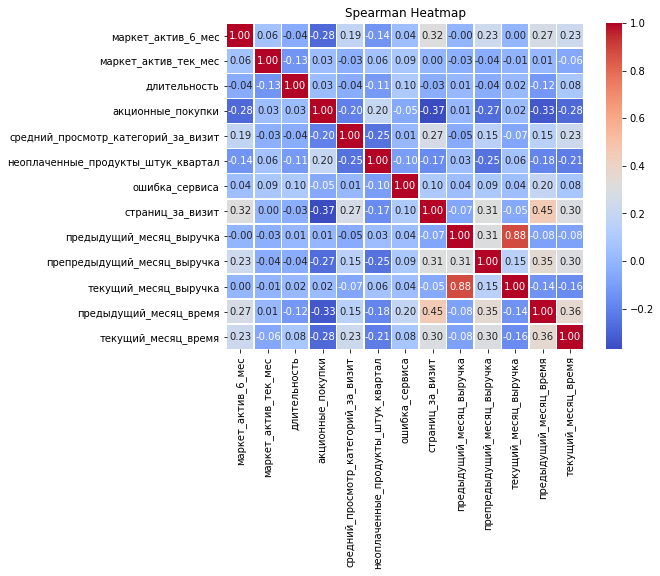

In [54]:
plt.figure(figsize=(8, 6))
sns.heatmap(spearman_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Spearman Heatmap")
plt.show()

На корреляционной матрице видно, что выручка в текущем и в предыдущем месяце имеют сильную корреляцию. При этом выручка в текущем месяце незначильно, но все же больше коррелирует с целевой переменной. При моделировании мы просто напросто не будем использовать столбец со значениями выручки за предыдущий месяц. 

## Пайплайн

В ходе подготовки пайплайна будут использованы четыре модели для обучения: 
 - SVC (C, class_weight, random_state)
 - Логистическая регрессия (class_weight, solver, random_state)
 - Дерево решений(max_depth, random_state, class_weight)
 - Метод ближайших соседей(n_neighbors)
 
Также, для оценки качества работы моделей будет использована метрика F1. Я решил выбрать именно ее, т.к. нам важно правильно распознать пользователей, покупательская способность которых снизится и простимулировать их, при этом не потратив деньги на ложноположительных пользователей. Так как наши классы несбалансированы, то лучше всего подойдет именно F1

В ходе подготовки данных к обучению будут использованы такие инструменты, как:
 - Масштабирование количественных признаков(StandartScaler, MinMaxScaler, RobustScaler)
 - Кодирование категориальных признаков(OneHotEncoder, OrdinalEncoder)
 
Для перебора гиперпараметров наших моделей применим RandomizedSearchCV

Теперь распределим столбцы для предобработки:
 - [`разрешить_сообщать`, `популярная_категория`] - OneHotEncoder;
 - [`тип_сервиса`] - OrdinalEncoder;

Целевой признак кодируем отдельно. 

In [55]:
market_total['покупательская_активность'] = market_total['покупательская_активность'].replace('прежний уровень', 0)
market_total['покупательская_активность'] = market_total['покупательская_активность'].replace('снизилась', 1)
market_total['покупательская_активность'].value_counts()

0    802
1    494
Name: покупательская_активность, dtype: int64

Целевой признак закодировали, прежде чем приступить к пайплайну выделим тренировочную и тестовую выборки. Валидационную выборку мы выделять не будем, т.к. в нашем пайплайне будет кросс-валидация. 

In [56]:
x = market_total.drop(['id', 'покупательская_активность', 'предыдущий_месяц_выручка'], 1)
y = market_total['покупательская_активность']

RANDOM_STATE=12345

x_train, x_test, y_train, y_test = train_test_split(
    x, 
    y, 
    test_size=0.25, 
    random_state=RANDOM_STATE, 
    stratify=y
)

Теперь начнем писать наш пайплайн. Он начнется с блока предобработки, где мы масштабируем и кодируем наши признаки. В этих блоках мы не будем включать SimpleImputer, так как наши данные не имеют пропусков, все значения были проверены на этапе предобработки и необходимости в проверке и замене неизвестных значений отпадает.

In [57]:
ohe_columns = ['разрешить_сообщать', 'популярная_категория']
ord_columns = ['тип_сервиса']
num_columns = market_total.drop(['id', 'покупательская_активность', 'предыдущий_месяц_выручка'], 1).select_dtypes(include='number').columns

In [58]:
ohe_pipe = Pipeline(
    [
        ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))
    ]
)

ord_pipe = Pipeline(
    [
        ('ord', OrdinalEncoder(
            categories=[
                ['стандарт', 'премиум']
            ], 
        )
        )
    ]
)


data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns), 
    ('ord', ord_pipe, ord_columns), 
    ('num', StandardScaler(), num_columns)
], 
    remainder='passthrough')

pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
]) 

In [59]:
%%time
param_distributions = [
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough']   
    },
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(class_weight='balanced', random_state=RANDOM_STATE, probability=True)],
        'models__C': range(1,10),
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough']  

    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(solver='liblinear', class_weight='balanced', random_state=RANDOM_STATE)],
        'models__solver': ['liblinear', 'lbfgs', 'sag', 'saga'],
        'models__max_iter': range(100, 1000),
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough']  
    }
] 

randomized_search  = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    cv=5, 
    scoring='f1',
    random_state=RANDOM_STATE,
    n_jobs=-2
)
randomized_search.fit(x_train, y_train) 

CPU times: user 2.43 s, sys: 1.36 s, total: 3.79 s
Wall time: 8.2 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              sparse=False))]),
                                                                               ['разрешить_сообщать',
                                                                                'популярная_категория']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('ord',
                                                                                                OrdinalEncoder(categories=[['стандарт',
                                                                                                                            'премиум']]))]),
                                                                               ['тип_сервиса']),
                                                                              ('num...
                                                               StandardScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(class_weight='balanced',
                                                                       max_iter=309,
                                                                       random_state=12345,
                                                                       solver='sag')],
                                         'models__max_iter': range(100, 1000),
                                         'models__solver': ['liblinear',
                                                            'lbfgs', 'sag',
                                                            'saga'],
                                         'preprocessor__num': [MinMaxScaler(),
                                                               StandardScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=12345, scoring='f1')

In [60]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_) 

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['стандарт',
                                                                                               'премиум']]))]),
                                                  

In [61]:
print('Метрика f1 для лучшей модели:\n', randomized_search.best_score_)

Метрика f1 для лучшей модели:
 0.8161489231293025


Итак, мы выяснили, что лучшая модель в нашем случае - это логистическая регрессия с числом итераций 309 и солвероми sag. 
Лучше всего масштабировать наши данные с MinMaxScaler

In [62]:
print('Метрика f1 на тестовой выборке:\n', f1_score(y_test, randomized_search.predict(x_test)))

Метрика f1 на тестовой выборке:
 0.8166666666666667


Наша модель хорошо взаимодействует с новыми данными, мы добились успеха! 

#### Вывод

В ходе исследования лучшей моделью для данной задачи оказалась логистическая регрессия со следующими параметрами:
 - `max_iter` - 309
 - `solver` - sag

Масштабирование наших данных лучше делать через MinMaxScaler.
 
Наш пайплайн выдал лучшую модель с метрикой f1 на валидации 0.82! При этом метрика на новых тестовых данных оказалась  0.82.

## Анализ важности признаков

Анализ важности признаков будем проводить с помощью значений Шепли. 

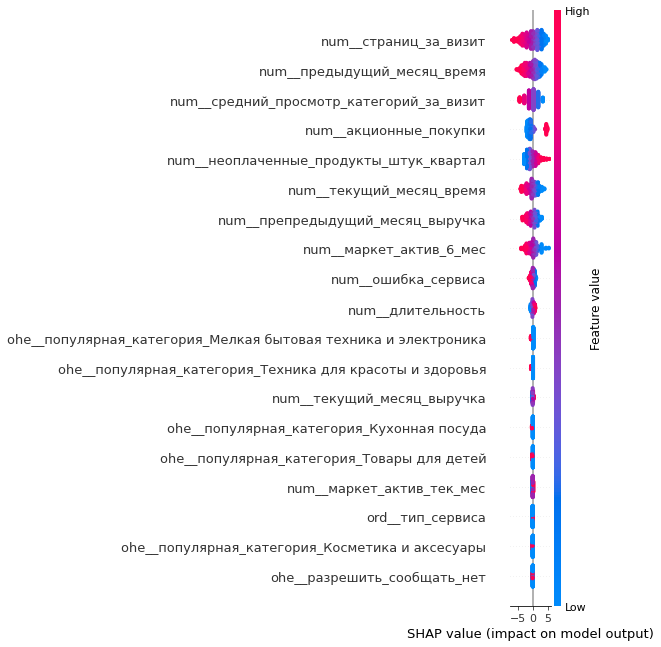

In [70]:
x_train_preprocessed = pipe_final.named_steps['preprocessor'].fit_transform(x_train)
explainer = shap.Explainer(randomized_search.best_estimator_.named_steps['models'], x_train_preprocessed)

x_test_preprocessed = pipe_final.named_steps['preprocessor'].transform(x_test)
shap_values = explainer(x_test_preprocessed)
shap.summary_plot(shap_values,
               x_test_preprocessed, 
               feature_names=pipe_final.named_steps['preprocessor'].get_feature_names_out())

Судя по графику мы можем сделать следующие выводы касательно вклада каждого признака в задаче классификации:

 - Чем **меньше страниц за визит** просматривает пользователь, тем **больше вероятность снижения** его покупательской активности.
 - Чем **меньше минут** проводит пользователь на сайте, тем **больше вероятность снижения** покупательской активности.
 - Чем **меньше среднее число просмотренных категорий за месяц**, тем **больше вероятность снижения** покупательской активности.
 - Чем **больше доля акционных покупок**, тем **больше вероятность снижения** покупательской активности.
 - Чем **больше количество неоплаченных товаров в корзине**, тем **больше вероятность снижения** покупательской активности.
 - Чем **меньше маркетинговых коммуникаций** с пользователем, тем **больше вероятность снижения** покупательской активности.
 
Вышеперечисленные признаки сильнее всего влияют на предсказания модели. Остальные признаки вносят не такой значительный вклад в предсказание класса. 

#### Вывод 

Для принятия бизнес решений в первую очередь стоит обратить внимание на признаки, которые наибольшим образом влияют на снижение покупательской активности. Их мы и перечислили выше. Так, например, можно поработать над улучшением рекомендаций пользователя, чтобы увеличить число страниц за визит. Тем самым мы увеличим время проведенное пользователем на сайте и число просмотренных категорий. Также стоит отметить что число неоплаченных товаров в корзине и доля акционных покупок могут быть взаимосвязаны, так как пользователь, добавляя товар в корзину может ожидать, когда на этот товар будет акция, поэтому не оплачивать покупку сразу. Маркетинговые коммуникации с пользователями тоже не маловажный показатель, т.к. еще на этапе исследовательского анализа данны мы выяснили, что это взаимодействие с пользователями нужно поддерживать, чтобы стимулировать его покупательскую активность. 


## Сегментация покупателей 

Для того, чтобы грамотно сегментировать покупателей обратимся к таблице с прибыльностью покупателей, а также проанализируем важность признаков

In [64]:
segment = market_total.merge(money, on='id', how='inner')
segment.head(10)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_время,текущий_месяц_время,прибыль
0,215349,1,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,4.16
1,215350,1,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13,3.13
2,215351,1,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,4.87
3,215352,1,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,4.21
4,215353,1,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10,3.95
5,215354,1,стандарт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2,5685.0,4503.0,5869.6,11,12,3.62
6,215355,1,стандарт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4,3263.0,4749.0,3772.6,12,10,5.26
7,215356,1,стандарт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3,4146.5,4433.0,4566.4,6,7,4.93
8,215358,1,стандарт,да,4.7,4,450,0.13,Домашний текстиль,4,2,6,4,3488.0,4727.0,4209.5,14,10,3.06
9,215360,1,премиум,да,3.9,3,623,0.35,Кухонная посуда,3,1,4,7,5304.5,5555.0,5834.9,9,6,4.55


Для начала исследуем прибыльность пользователей, в зависимости от группы

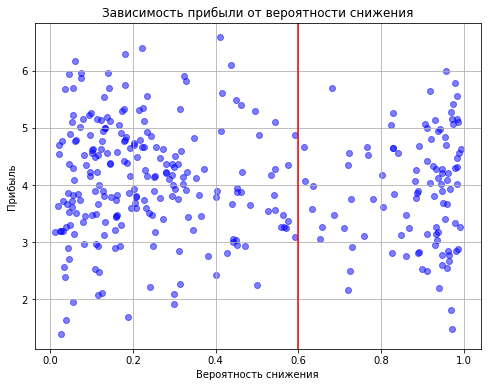

In [65]:
probas = randomized_search.predict_proba(x_test)[:, 1]
profit = segment.iloc[x_test.index]['прибыль']


plt.figure(figsize=(8, 6))
plt.scatter(probas, profit, color='blue', alpha=0.5)  
plt.title('Зависимость прибыли от вероятности снижения')  
plt.xlabel('Вероятность снижения')  
plt.ylabel('Прибыль')  
plt.grid(True)  
plt.axvline(x=0.6, color='r', linestyle='-')
plt.show()  

На диаграмме рассеяния видно, что пользователи поделились на два сегмента. Данные сегменты разделены вертикальной красной линией по пороговому значению вероятности снижения 0.6. Будем исследовать сегмент пользователей, вероятность снижения покупательской активности которых больше 0.6. Достанем индексы этих пользователей и выделим в этом сегменте группу пользователей.

In [66]:
users = pd.DataFrame(index=x_test.index, data=probas, columns=['probas'])
segment_higher_06 = segment.loc[users[users['probas'] >= 0.6].index]
segment_higher_06.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_время,текущий_месяц_время,прибыль
269,215621,1,премиум,да,3.5,3,1076,0.22,Кухонная посуда,4,3,3,7,5025.0,4578.0,5582.7,7,11,4.66
124,215476,1,премиум,да,3.1,4,666,0.39,Кухонная посуда,3,3,2,2,5053.0,4243.0,5957.8,6,11,2.84
75,215427,1,стандарт,нет,2.4,4,186,0.40,Косметика и аксесуары,3,6,7,6,5549.5,4795.0,6427.0,9,14,2.76
757,216109,0,премиум,да,4.4,3,1038,0.28,Кухонная посуда,2,1,1,6,5304.0,5178.0,5543.2,12,13,4.66
763,216115,0,стандарт,нет,4.4,4,808,0.17,Мелкая бытовая техника и электроника,4,2,0,3,4802.5,4543.0,5157.4,11,9,4.06


____

В ходе исследования мы вывели, что доля акционных покупок обратнопропорционально влияет на покупательскую активность пользователей. Мы определили, что пороговое значение доли акционных покупок, при котором повально снижается покупательская активность это 0.6.

In [67]:
print('Средняя прибыльность пользователей с низкой долей акционных покупок', 
     segment_higher_06[segment_higher_06['акционные_покупки'] <= 0.6]['прибыль'].mean())

print('Средняя прибыльность пользователей с высокой долей акционных покупок', 
     segment_higher_06[segment_higher_06['акционные_покупки'] > 0.6]['прибыль'].mean())

Средняя прибыльность пользователей с низкой долей акционных покупок 3.8257534246575338
Средняя прибыльность пользователей с высокой долей акционных покупок 4.118214285714286


Так точно, прибыль с пользователей, совершающих в большинстве своем акционные покупки выше, поэтому с этой группой мы и будем работать.

In [68]:
segment_higher_06[segment_higher_06['акционные_покупки'] > 0.6].value_counts('популярная_категория')

популярная_категория
Косметика и аксесуары                   9
Кухонная посуда                         6
Товары для детей                        5
Домашний текстиль                       4
Техника для красоты и здоровья          3
Мелкая бытовая техника и электроника    1
dtype: int64

Пользователи, у которых высокая доля акционных покупок чаще покупают товары для дома и ухода. 

In [69]:
segment_higher_06[segment_higher_06['акционные_покупки'] > 0.6].groupby('популярная_категория')['прибыль'].mean().sort_values(ascending=False)

популярная_категория
Техника для красоты и здоровья          5.116667
Товары для детей                        4.534000
Косметика и аксесуары                   4.094444
Кухонная посуда                         3.806667
Домашний текстиль                       3.615000
Мелкая бытовая техника и электроника    3.140000
Name: прибыль, dtype: float64

При этом прибыль с таких пользователей выше в категориях ухода за собой и товаров для детей

#### Вывод

Учитывая тот факт, что выбранная группа пользователей чаще обращают внимание на Товары для ухода и детей, работать мы будем именно с этими категориями и увеличивать покупательскую активность данной группы, т.к. она является наиболее прибыльной. Важно учесть, что при анализе важности признаков мы определили ряд признаков, которые наибольшим образом влияют на снижение покупательской активности. Таким образом, для увеличения покупательской активности можно предложить следующие действия:

 - Улучшить рекомендательные алгоритмы, чтобы сайт чаще предлогал пользователям сопуствующие товары для детей и ухода, тем самым увеличивая время пребывания на сайте и количество просмотренных страниц.
 - Ввести доп. скидки на покупку от определенного количества товаров данных категорий. Таким образом мы сможем избежать скопления неоплаченных товаров в корзине, а таже увеличим покупательскую активность пользователей, доля акционных покупок которых выше 0.6
 - Увеличить число персонализированных предложений для пользователей в категориях Товары для детей, Косметика и аксессуары, Техника для красоты и ухода, тем самым увеличив число маркетинговых коммуникаций и уровень лояльности клиентов к сервису. Также, как вариант, можно предлажить какие-то интерактивные мероприятия по стимулированию вовлеченности пользователей в жизнь сервиса: например, можно предложить акцию "Лучшее видео с описанием опыта покупателей в использовании купленного товара" или же "Лучшее фото". Таким образом будет создаваться целое комьюнити, где множество пользователей будут обмениваться опытом использования товаров и участвовать в конкурсах. 

## Общий вывод

#### Описание задачи

Перед нами стояла задача разработать решение, которое позволит персонализировать предложения клиентам, чтобы увеличить их покупательскую активность. Данные были переданы компанией "В один клик" - интернет магазин, который продает разные товары для дома, детей, технику, товары для красоты и аксессуары. В арсенале у нас было 4 таблицы, которые содержали основную информацию о пользователях. Необходимо было провести предобработку данных, провести исследовательский анализ данных, выделить пользователей с покупательской активностью не менее 3-х месяцев. После этого нужно было провести корреляционных анализ, написать пайплайн для вывода лучшей модели, провести анализ важности признаков и провести сегментацию пользователей. На этапе сегментации необходимо было выделить группу пользователей и сформулировать предложения для увеличения их покупательской активности.


#### Описание данных и предобработки

`market_file.csv` - Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении:
- `id` — номер покупателя в корпоративной базе данных.
- `Покупательская активность` — рассчитанный класс покупательской активности **(целевой признак): «снизилась» или «прежний уровень».**
- `Тип сервиса` — уровень сервиса, например **«премиум»** и **«стандарт».**
- `Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- `Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- `Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце.
- `Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- `Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.
- `Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- `Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.
- `Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта.
- `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.
___
`market_money.csv` - Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом:

- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксирована выручка. Например, **'текущий_месяц'** или **'предыдущий_месяц'**.
- `Выручка` — сумма выручки за период.
___
`market_time.csv` - Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода:
- `id`— номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксировано общее время.
- `минут` — значение времени, проведённого на сайте, в минутах.
___
`money.csv` - Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю:
- `id` — номер покупателя в корпоративной базе данных.
- `Прибыль` — значение прибыли.


В ходе предобработки данных были предприняты следующие шаги по устранению недочетов в данных:
- Мы **написали функцию `preprocessing`**, которая исправляет недочеты в названиях столбцов наших датафреймов:

    1) Все символы в названиях столбцов были приведены к нижнему регистру;
    
    2) Пробелы в названиях столбцов были заменены на нижнее подчеркивание.
___    
- Мы **написали функцию `check_data`**, которая перебирает каждый столбец и выводит список уникальных значений, считает дубликаты, а также выводит на экран гистограммы столбцов с количественным типом данных: 

    1) С помощью функции был обнаружен неявный дубликат в столбце `тип_сервиса` датафрейма `market_file`;
    
    2) Также мы обнаружили один выброс в датасете `market_money` в столбце с выручками. Выброс всего один и принадлежит пользователю с `id` **215380**. Мы его удалили, это менее 1% данных
    
    3) Обнаружена орфографическая ошибка в столбце `тип_сервиса`
___    
В основном все недочеты, как мне кажется, являются следствием человеческого фактора.

#### Шаги для поиска лучшей модели

Для поиска лучшей модели мы написали пайплайн, где для начала расписали этапы предобработки:
 - Кодирование категориальных признаков. Мы использовали 2 кодировщика: OneHotEncoder и OrdinalEncoder. В OrdinalEncoder мы передали столбец типом сервиса. В OneHotEncoder мы отдали оставшиеся категориальные столбцы.
 - Масштабирование количественных признаков. Для подбора лучшего скелера мы решили использовать RandomizedSearchCV. В него мы передали 3 скелера: MinMax, Robust, Standart. Также мы добавили вариант без масштабирования, на случай, если модели это не нужно. 
 
Далее мы выбрали несколько моделей для поиска лучшей и передали в RandomizedSearchCV параметры для перебора:
 - SVC (C, class_weight, random_state)
 - LogisticRegression (class_weight, solver, random_state)
 - DecisionTreeClassifier (max_depth, random_state, class_weight)
 - KNeighborsClassifier (n_neighbors)

#### Лучшая модель

В ходе исследования лучшей моделью для данной задачи оказалась логистическая регрессия со следующими параметрами:
 - `max_iter` - 309
 - `solver` - sag

Масштабирование наших данных лучше делать через MinMaxScaler.
 
Наш пайплайн выдал лучшую модель с метрикой f1 на валидации 0.81! При этом метрика на новых тестовых данных оказалась  0.81.

#### Вывод

Учитывая тот факт, что выбранная группа пользователей чаще обращают внимание на Товары для ухода и детей, работать мы будем именно с этими категориями и увеличивать покупательскую активность данной группы, т.к. она является наиболее прибыльной. Важно учесть, что при анализе важности признаков мы определили ряд признаков, которые наибольшим образом влияют на снижение покупательской активности. Таким образом, для увеличения покупательской активности можно предложить следующие действия:

 - Улучшить рекомендательные алгоритмы, чтобы сайт чаще предлогал пользователям сопуствующие товары для детей и ухода, тем самым увеличивая время пребывания на сайте и количество просмотренных страниц.
 - Ввести доп. скидки на покупку от определенного количества товаров данных категорий. Таким образом мы сможем избежать скопления неоплаченных товаров в корзине, а таже увеличим покупательскую активность пользователей, доля акционных покупок которых выше 0.6
 - Увеличить число персонализированных предложений для пользователей в категориях Товары для детей, Косметика и аксессуары, Техника для красоты и ухода, тем самым увеличив число маркетинговых коммуникаций и уровень лояльности клиентов к сервису. Также, как вариант, можно предлажить какие-то интерактивные мероприятия по стимулированию вовлеченности пользователей в жизнь сервиса: например, можно предложить акцию "Лучшее видео с описанием опыта покупателей в использовании купленного товара" или же "Лучшее фото". Таким образом будет создаваться целое комьюнити, где множество пользователей будут обмениваться опытом использования товаров и участвовать в конкурсах. 